In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch
# from utility import get_all_files_paths

In [16]:
TRAIN = False

BATCH_SIZE = 128
LATENT_SPACE_DIM = 128
LEARNING_RATE = 1e-5

SAVE_ROUND = 20
NUM_EPOCHS = 500

torch.manual_seed(0) # random seed for reproducible results

In [17]:
dataset_path="data/spec/fma_small"
model_save_path = "models/Echoes"
csv_save_path = "output/Echoes_output"

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'device: {device}')

device: cuda


In [18]:
class MusicDataset(Dataset):
	def __init__(self, file_paths):
		self.file_paths = file_paths

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, idx):
		file_path = self.file_paths[idx]
		data = np.load(file_path)
		data = data[np.newaxis, :, :]  # Add a channel dimension
		data = torch.tensor(data, dtype=torch.float32)

		filename = os.path.basename(file_path)
		label = filename.replace(".mp3", "").lstrip("0")
		return data, label

file_paths = []
for root, dirs, files in os.walk(dataset_path):
	for file in files:
		file_paths.append(os.path.join(root, file))

# 取出20%的数据作为测试集，10%的数据作为验证集，剩下的作为训练集（理论上每个文件夹有风格区别，应该尽量做到比例均匀），但是（先验的）风格不好分，暂时直接随机划分
m = len(file_paths)
test_size = int(m * 0.2)
valid_size = int((m - test_size) * 0.1)
train_size = m - test_size - valid_size

paths = np.array(file_paths)
np.random.shuffle(paths)

train_paths = paths[:train_size]
valid_paths = paths[train_size:train_size + valid_size]
test_paths = paths[train_size + valid_size:]

train_dataset = MusicDataset(train_paths)
valid_dataset = MusicDataset(valid_paths)
test_dataset = MusicDataset(test_paths)

print(f'Training set size:   {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size:       {len(test_dataset)}')

if TRAIN:
	train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
	valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
	test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size:   5757
Validation set size: 639
Test set size:       1598


In [19]:
if TRAIN:
	loss_fn = torch.nn.MSELoss()
	
	encoder = Encoder(encoded_space_dim=LATENT_SPACE_DIM)
	decoder = Decoder(encoded_space_dim=LATENT_SPACE_DIM)
	params_to_optimize = [
		{'params': encoder.parameters()},
		{'params': decoder.parameters()}
	]

	optim = torch.optim.Adam(params_to_optimize, lr=LEARNING_RATE, weight_decay=1e-05)

	encoder = encoder.to(device)
	decoder = decoder.to(device)
	
	losses = {'train_loss':[],'val_loss':[]}

	for epoch in range(NUM_EPOCHS):
		train_loss =train_epoch(encoder, decoder, device,train_loader, loss_fn, optim)
		val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
	
		print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, NUM_EPOCHS,train_loss,val_loss))

		# track losses
		losses['train_loss'].append(train_loss)
		losses['val_loss'].append(val_loss)

		# save model
		if (epoch + 1) % SAVE_ROUND == 0: 
			torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
			torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	plt.figure(figsize=(8,6))
	plt.semilogy(losses['train_loss'], label='Train')
	plt.semilogy(losses['val_loss'], label='Valid')
	plt.xlabel('Epoch')
	plt.ylabel('Average Loss')
	# plt.grid()
	plt.legend()
	plt.title('loss')
	plt.show()
	
	encoder_path = f"{model_save_path}/encoder.pth"
	decoder_path = f"{model_save_path}/decoder.pth"
	torch.save(encoder.state_dict(), encoder_path)
	torch.save(decoder.state_dict(), decoder_path)

```
TRAIN = True

BATCH_SIZE = 128
LATENT_SPACE_DIM = 128
LEARNING_RATE = 1e-5

SAVE_ROUND = 20
NUM_EPOCHS = 500

torch.manual_seed(0) # random seed for reproducible results
```

training log:
epoch 300 后开始 overfitting

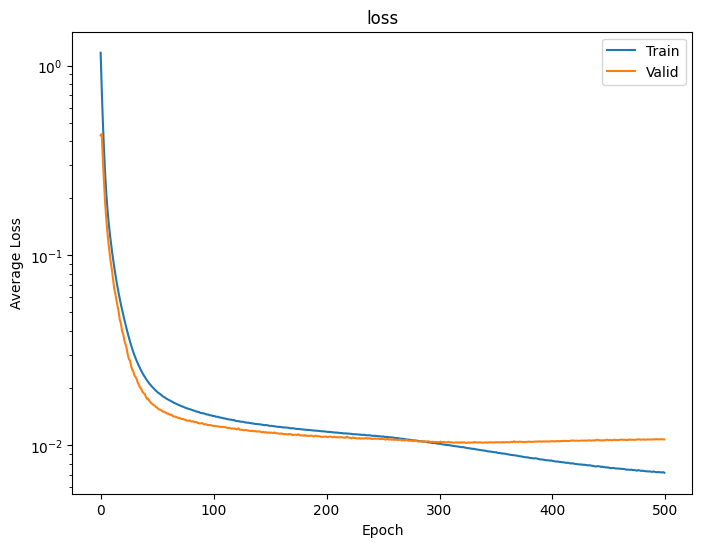

In [21]:
from tqdm import tqdm

if not TRAIN:
	encoder_path = f"{model_save_path}/encoder_280.pth"
	encoder = load_encoder(encoder_path, LATENT_SPACE_DIM)
	encoder = encoder.to(device)

encoded_samples = []
for sample in tqdm(test_dataset):
	data = sample[0].unsqueeze(0).to(device)
	label = sample[1]
	encoder.eval()
	with torch.no_grad():
		encoded_img = encoder(data)

	encoded_img = encoded_img.flatten().cpu().numpy()
	encoded_sample = {f"enc. v {i}": enc for i, enc in enumerate(encoded_img)}
	encoded_sample['label'] = label
	encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/fma_small_encoded.csv", index=False)
encoded_samples

/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.devic

,enc. v 0,enc. v 1,enc. v 2,enc. v 3,enc. v 4,enc. v 5,enc. v 6,enc. v 7,enc. v 8,enc. v 9,...,enc. v 119,enc. v 120,enc. v 121,enc. v 122,enc. v 123,enc. v 124,enc. v 125,enc. v 126,enc. v 127,label
0,-0.547712,-0.213847,0.060785,-0.216451,0.731972,-0.006007,-0.135720,-0.140588,0.695027,-0.030387,...,-0.120465,-0.365982,0.423422,0.521820,0.416701,-0.026492,-0.399771,0.046480,-1.109472,52635.npy
1,-0.028083,-0.102869,0.420535,-0.544643,0.877177,-0.286636,0.273842,-0.587904,-0.061543,-0.321960,...,-0.949638,-0.227004,-0.008375,0.016797,0.034327,0.060348,0.307535,0.285944,-0.478513,19192.npy
2,-0.018466,0.400346,0.242583,-0.361488,0.516055,0.288970,0.483558,-0.444177,0.119046,-0.181779,...,-0.499797,-0.151201,0.001322,0.259224,-0.094214,-0.256807,0.323226,-0.105210,-0.372494,55076.npy
3,0.114607,-0.235036,-0.422756,-0.202085,0.065973,0.662191,0.827218,-0.335366,0.186521,0.485570,...,-0.483309,-0.069050,0.006874,0.486741,-0.355329,-0.090412,-0.037276,0.563724,-0.472847,133969.npy
4,-0.494619,-0.149178,-0.033392,-0.022157,0.297046,0.139414,0.793314,0.105730,-0.234549,-0.124850,...,-0.815302,-0.041090,0.146227,-0.095882,-0.379217,-0.653050,-0.134621,0.306386,-0.410446,55240.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,-0.083873,-0.031765,-0.242106,-0.291358,0.391183,0.385748,0.734141,-0.444881,-0.162056,0.110465,...,-0.041997,-0.496235,-0.086114,0.648987,-0.385312,-0.235957,-0.024681,-0.316632,-0.479606,98301.npy
1594,-0.784081,-0.716051,-0.480199,0.956721,-0.030851,0.560734,0.463433,0.579827,0.518063,-0.537566,...,-0.247150,-0.726943,-0.106405,0.178462,0.361624,-1.082511,0.249228,-0.359513,0.047024,56687.npy
1595,0.077148,0.163023,0.030754,1.045849,-0.193139,0.302504,-0.268748,-0.698257,-0.333044,0.256008,...,-0.309499,-0.488225,0.312137,0.823240,-0.259813,-0.501065,-0.040559,-0.283792,0.443136,43587.npy
1596,0.342106,-0.339053,0.617584,0.243760,0.226275,0.067264,0.109775,-0.025203,-0.239255,-0.419661,...,0.504895,-0.426590,-0.320530,0.346178,0.761440,0.225843,-0.213690,-0.168924,-0.086677,88960.npy
